In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# CODE PERSO
import mbr_kernel as mkn
from outils_classification_810 import compute_F2, compute_F2_custom, matrice_de_confusion_binaire
import outils_grid_search_810 as gs810
import outils_mlflow_810 as ml810


NOM_MODELE_BASE='XGBoost'

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
TMP_FOLDER = GIT_FOLDER+'tmp/'

In [6]:
# ---------------------------------------------------------------- MAKE SCRORER
F2_score = make_scorer(compute_F2, greater_is_better=True)
F2custom_score = make_scorer(compute_F2_custom, greater_is_better=True)

In [7]:
def transform_X(X):
    """Applique les transformation qui precede l'estimator dans le Pipeline. Permet d'obtenir une version des donnees telle que l'estimator traitera"""
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X


def test_model(data, estimator, confusion=False, over_sampling=0.1, under_sampling=0.5, do_under=True) :
    """Permet de tester un model, sans enregistrer les resultats dans MLFlow"""
    print("PREPARING MODEL")
    X = data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    y = data['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
    print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    over = SMOTE(sampling_strategy=over_sampling, random_state=RANDOM_STATE)
    if do_under :
        under = RandomUnderSampler(sampling_strategy=under_sampling, random_state=RANDOM_STATE)
    estimator = estimator

    if do_under :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("under", under),
            ("estimator", estimator)
        ])
    else :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("estimator", estimator)
        ])

    be.fit(X_train, y_train)

    print("TESTING MODEL")
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = compute_F2(y_true=y_train, y_pred=y_train_pred)
    train_F2c_score = compute_F2_custom(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print("TRAIN F2 score", train_F2_score)
    print("TRAIN F2Custom score", train_F2c_score)
    print("TRAIN AUC", train_auc_score)
    print("TRAIN Recall", train_rappel)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = compute_F2(y_true=y_test, y_pred=y_pred)
    test_F2c_score = compute_F2_custom(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("TEST F2 score", test_F2_score)
    print("TEST F2Custom score", test_F2c_score)
    print("TEST AUC", test_auc_score)
    print("TEST Recall", test_rappel)

    if confusion :
        matrice_de_confusion_binaire(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=TMP_FOLDER, nomfichier="model_Test_cm.png")
    return {'model' : be, 'test_F2' : test_F2_score, 'test_aux' : test_auc_score, 'test_rappel' : test_rappel}


# PREPROCESS DATA

In [8]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 17)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 8s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 26s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 6s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 15s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)


# GRIDSEARCH

In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = xgb.XGBClassifier(gamma=0.1, learning_rate=0.05, scale_pos_weight=2)

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__max_depth' : [3, 4, 5, 6],
    'estimator__min_child_weight' : [200, 300, 400],
    'estimator__colsample_bytree': [0.2, 0.3],
    'estimator__subsample': [0.2, 0.3, 0.4],
    'estimator__n_estimators': [400, 500, 600]
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=F2_score,
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

model.fit(X_train, y_train)

model

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=400, estimator__subsample=0.2; total time=  14.1s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=400, estimator__subsample=0.3; total time=  15.5s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=500, estimator__subsample=0.2; total time=  16.2s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=500, estimator__subsample=0.4; total time=  20.0s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=600, estimator__subsample=0.2; total time=  20.9s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estim

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=No...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'estimator__colsample_bytree': [0.2, 0.3],
                         'estimator__max_depth': [3, 4, 5, 6],
                         'estimator__min_child_weight': [200, 300, 400],
                         'estimator__n_estimators': [400, 500, 600],
                         'estimator__subsample': [0.2, 0.3, 0.4]},
             return_train_score=True, scoring=make_scorer(compute_F2),
             verbose=2)

24 minutes pour 405 fits de XGBoost

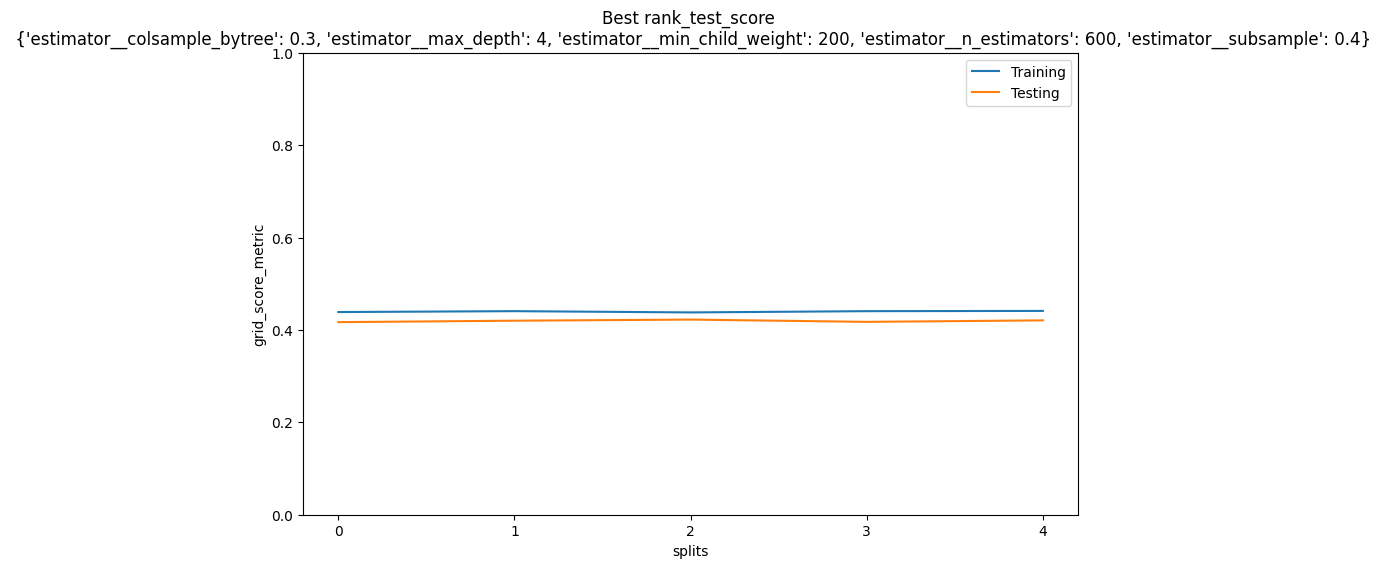

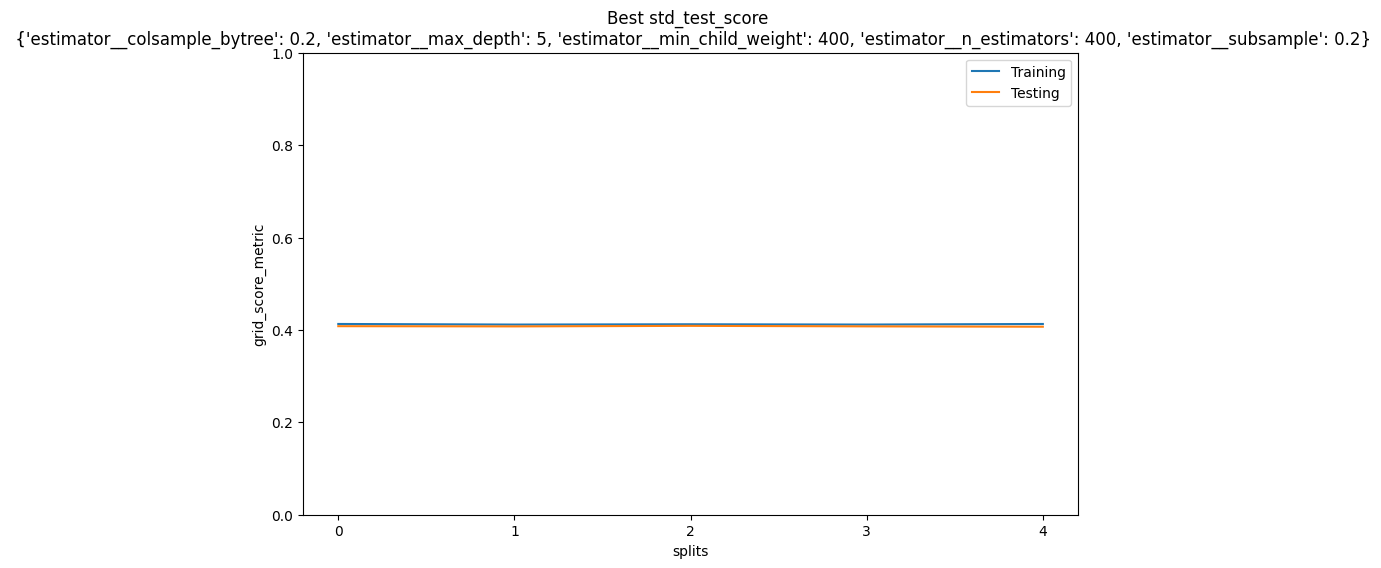

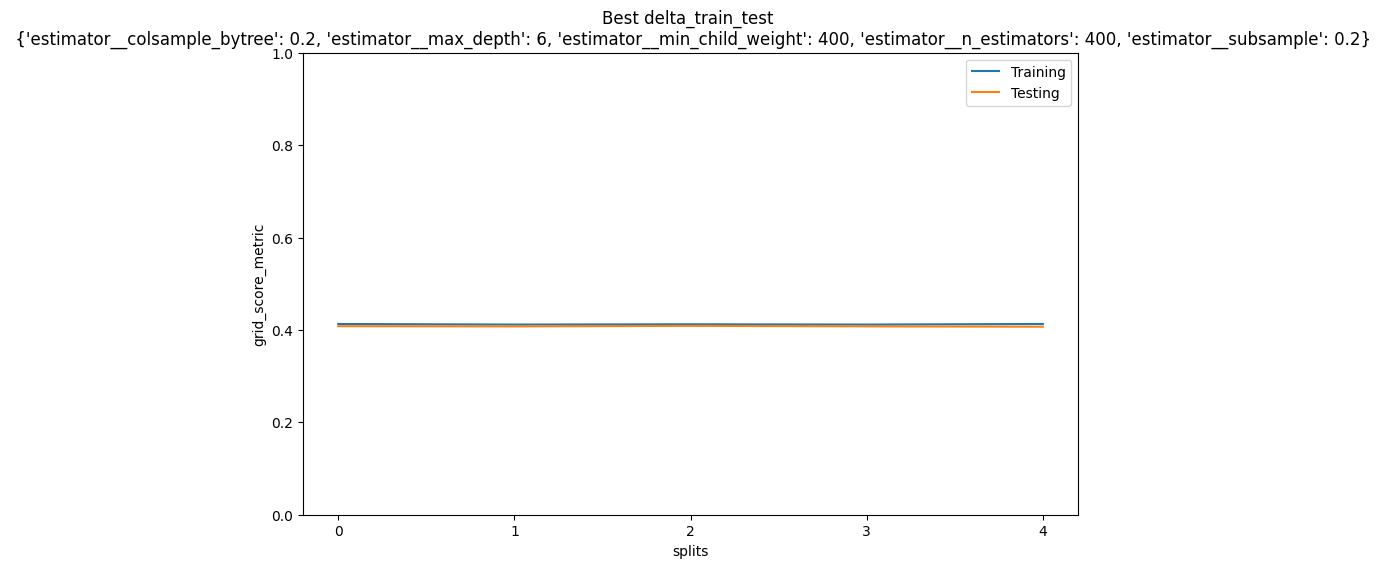

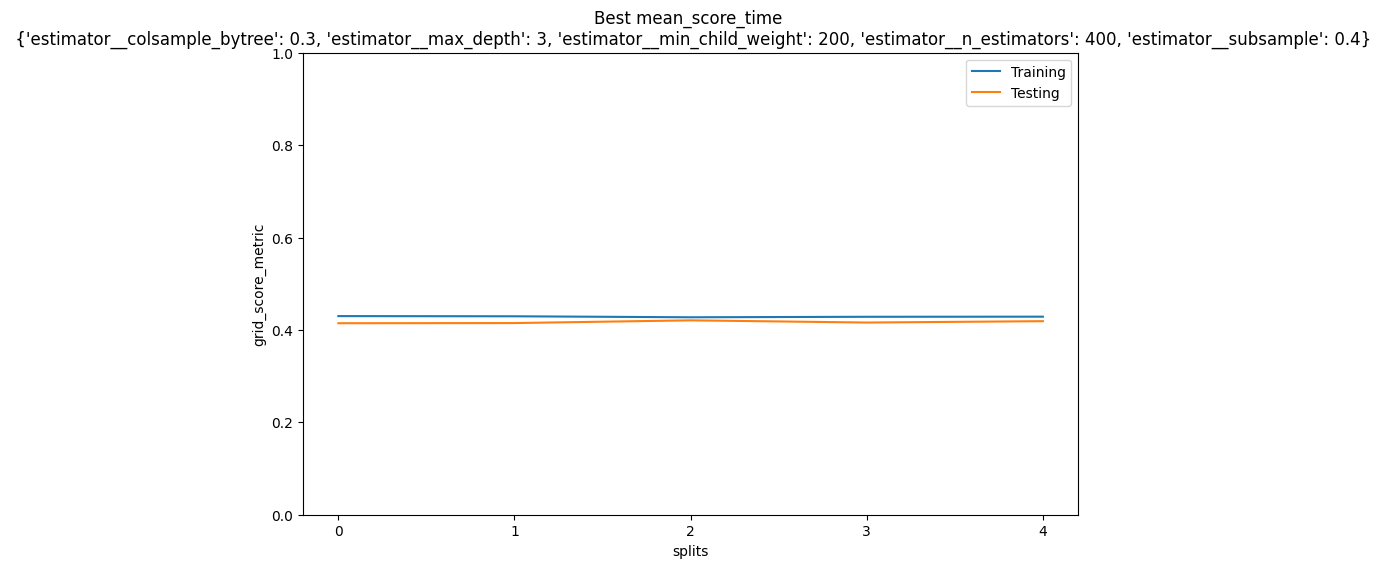

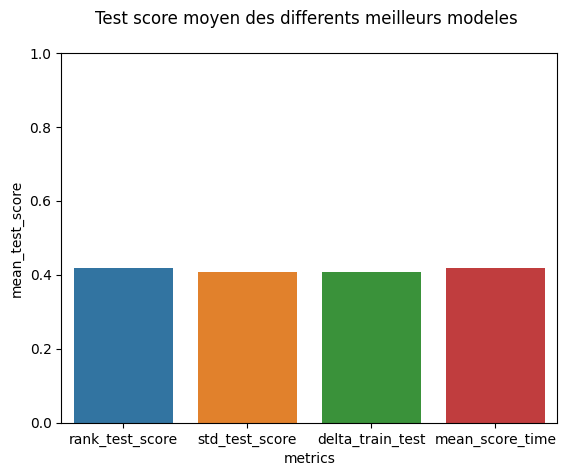

In [10]:
grid_results = gs810.grid_resultification(grid=model)
df_to_plot, df_models = gs810.get_split_scores_for_model(res_grid=grid_results, nb_cv=5)
list_img, path_to_models_csv =gs810.plot_split_scores(df_to_plot, df_models, save=True, path=TMP_FOLDER)

In [11]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__colsample_bytree,param_estimator__max_depth,param_estimator__min_child_weight,param_estimator__n_estimators,param_estimator__subsample,params,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,delta_train_test
0,13.937918,0.251420,0.330903,0.010358,0.2,3,200,400,0.2,"{'estimator__colsample_bytree': 0.2, 'estimato...",...,0.002846,149,0.421898,0.421350,0.420334,0.420367,0.421479,0.421086,0.000627,0.008231
1,14.888314,0.311956,0.304619,0.016628,0.2,3,200,400,0.3,"{'estimator__colsample_bytree': 0.2, 'estimato...",...,0.004102,63,0.426658,0.424655,0.425108,0.425233,0.424469,0.425225,0.000770,0.009026
2,16.748742,0.249724,0.308053,0.017869,0.2,3,200,400,0.4,"{'estimator__colsample_bytree': 0.2, 'estimato...",...,0.003370,97,0.429814,0.426673,0.425676,0.427983,0.427784,0.427586,0.001389,0.012056
3,16.097570,0.214520,0.407583,0.032035,0.2,3,200,500,0.2,"{'estimator__colsample_bytree': 0.2, 'estimato...",...,0.003173,141,0.425682,0.423335,0.421734,0.422851,0.424190,0.423559,0.001326,0.009988
4,18.368361,0.653956,0.363845,0.013143,0.2,3,200,500,0.3,"{'estimator__colsample_bytree': 0.2, 'estimato...",...,0.003336,57,0.428534,0.427229,0.426474,0.428838,0.427301,0.427675,0.000880,0.011241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,26.016046,0.617565,0.609349,0.033751,0.3,6,400,500,0.3,"{'estimator__colsample_bytree': 0.3, 'estimato...",...,0.002254,150,0.423043,0.421011,0.421620,0.422982,0.424423,0.422616,0.001196,0.009821
212,32.442262,0.403422,0.728191,0.020987,0.3,6,400,500,0.4,"{'estimator__colsample_bytree': 0.3, 'estimato...",...,0.003245,67,0.430128,0.430405,0.430653,0.429891,0.429276,0.430071,0.000473,0.013926
213,22.059906,0.292992,0.510408,0.013725,0.3,6,400,600,0.2,"{'estimator__colsample_bytree': 0.3, 'estimato...",...,0.001944,210,0.415330,0.412525,0.411796,0.413040,0.415713,0.413681,0.001559,0.006357
214,30.584778,0.437440,0.685623,0.005351,0.3,6,400,600,0.3,"{'estimator__colsample_bytree': 0.3, 'estimato...",...,0.003563,140,0.423304,0.423770,0.422864,0.424933,0.426298,0.424234,0.001241,0.010568


mean_score_time / mean_test_score
BEST SCORE MEAN MODEL :
- 0.552239 / 0.419455
BEST MEAN SCORE TIME :
- 0.292824 / 0.416992

Si on regarde le deuxieme best model :
- 0.395471 / 0.419020

In [19]:
print("Best Model Vs. Fastest : ")
print("-----")
print("Perte de score : ", (1 - 0.416992/0.419455))
print("Gain de temps : ", (1 - 0.292824/0.552239))
print()
print("Best Model Vs. 2nd best : ")
print("-----")
print("Perte de score : ", (1 - 0.419020/0.419455))
print("Gain de temps : ", (1 - 0.395471/0.552239))

Best Model Vs. Fastest : 
-----
Perte de score :  0.00587190521033254
Gain de temps :  0.469751321438725

Best Model Vs. 2nd best : 
-----
Perte de score :  0.0010370599945167536
Gain de temps :  0.28387708944859025


Le model le plus rapide semble offrir le meilleur compromis precision/temps

In [12]:
df_models

,metrics,best_params,mean_test_score,metric_value
0,rank_test_score,"{'estimator__colsample_bytree': 0.3, 'estimato...",0.419455,1.000000
1,std_test_score,"{'estimator__colsample_bytree': 0.2, 'estimato...",0.407836,0.000608
2,delta_train_test,"{'estimator__colsample_bytree': 0.2, 'estimato...",0.407836,0.004405
3,mean_score_time,"{'estimator__colsample_bytree': 0.3, 'estimato...",0.416992,0.292824


- min_child_weight fonctionne comme pour la random forest : Une valeur elevee permet d'accelerer le processus, mais risque de reduire la precision
- scale_pos_weight est determinant pour compenser notre unbalanced dataset

In [13]:
ml810.save_grid_results(list_of_image=list_img,
                        grid_estimator=NOM_MODELE_BASE,
                        ini_params="gamma=0.1, max_depth=6, subsample=0.2, n_estimators=500, learning_rate=0.05",
                        path_to_csv=path_to_models_csv)

In [17]:
grid_results.to_csv('./processed_data/grid_xgboost_results_06-09.csv')

# TEST MODEL

{'estimator__colsample_bytree': 0.3, 'estimator__max_depth': 3, 'estimator__min_child_weight': 200, 'estimator__n_estimators': 400, 'estimator__subsample': 0.4}

PREPARING MODEL
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.4280664146969782
TRAIN F2Custom score 0.5187126174878952
TRAIN AUC 0.7104186224911522
TRAIN Recall 0.6978312514368917
TEST F2 score 0.4107707361132018
TEST F2Custom score 0.4965765109983849
TEST AUC 0.6951835721619948
TEST Recall 0.6692213366033108


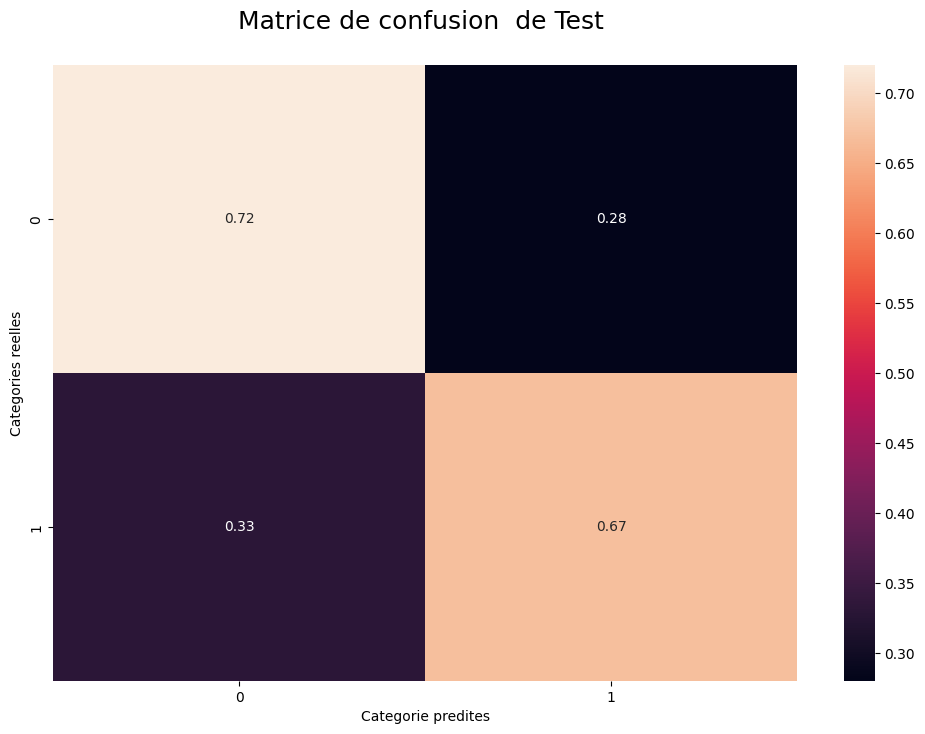

In [22]:
dict_results = test_model(df, xgb.XGBClassifier(gamma=0.1,
                                                max_depth=3,
                                                n_estimators=400,
                                                learning_rate=0.05,
                                                colsample_bytree=0.3,
                                                min_child_weight=200,
                                                scale_pos_weight=2,
                                                subsample=0.4),
                          confusion=True, over_sampling=0.1, under_sampling=0.5, do_under=True)

Il est finalement moins bon que celui que nous avions obtenu precedemment.

PREPARING MODEL
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.4300183813079153
TRAIN F2Custom score 0.5194010036679083
TRAIN AUC 0.7117386541393086
TRAIN Recall 0.695608858916392
TEST F2 score 0.4126664895837286
TEST F2Custom score 0.49714285714285716
TEST AUC 0.6965513802604656
TEST Recall 0.6667688534641324


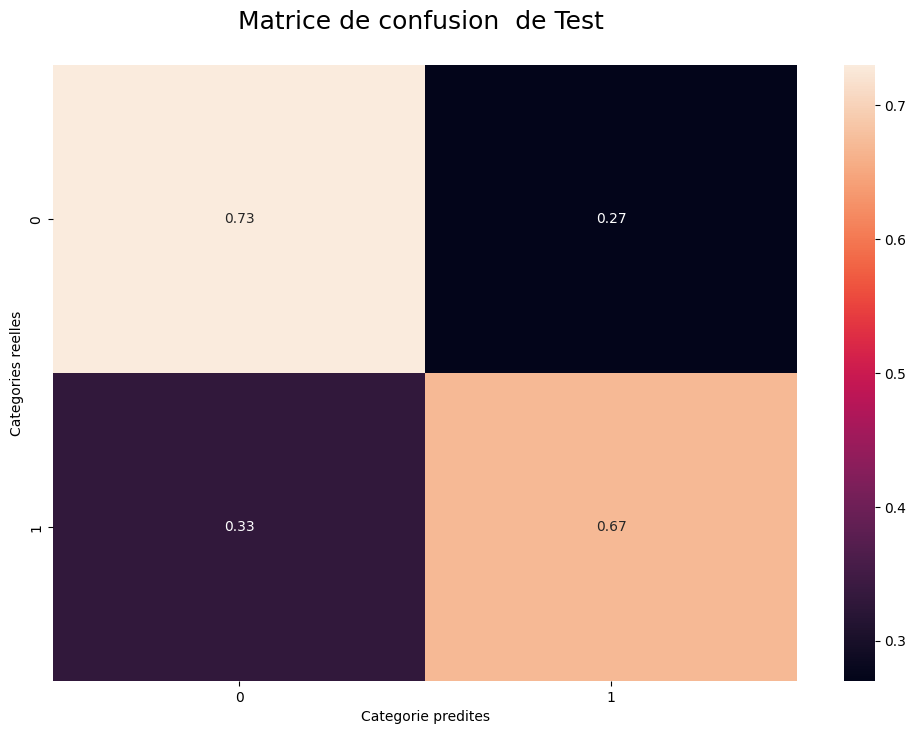

In [27]:
dict_results = test_model(df, xgb.XGBClassifier(gamma=0.1,
                                                max_depth=6,
                                                n_estimators=500,
                                                learning_rate=0.05,
                                                colsample_bytree=0.4,
                                                min_child_weight=400,
                                                scale_pos_weight=2,
                                                subsample=0.3),
                          confusion=True, over_sampling=0.1, under_sampling=0.5, do_under=True)

# SAVE MODEL

In [25]:
xgb.XGBClassifier(gamma=0.1,
                    max_depth=6,
                    n_estimators=500,
                    learning_rate=0.05,
                    colsample_bytree=0.4,
                    min_child_weight=400,
                    scale_pos_weight=2,
                    subsample=0.3)

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.3, ea...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=200, missing=nan,
                               monotone_constraints=None, n_estimators=400,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

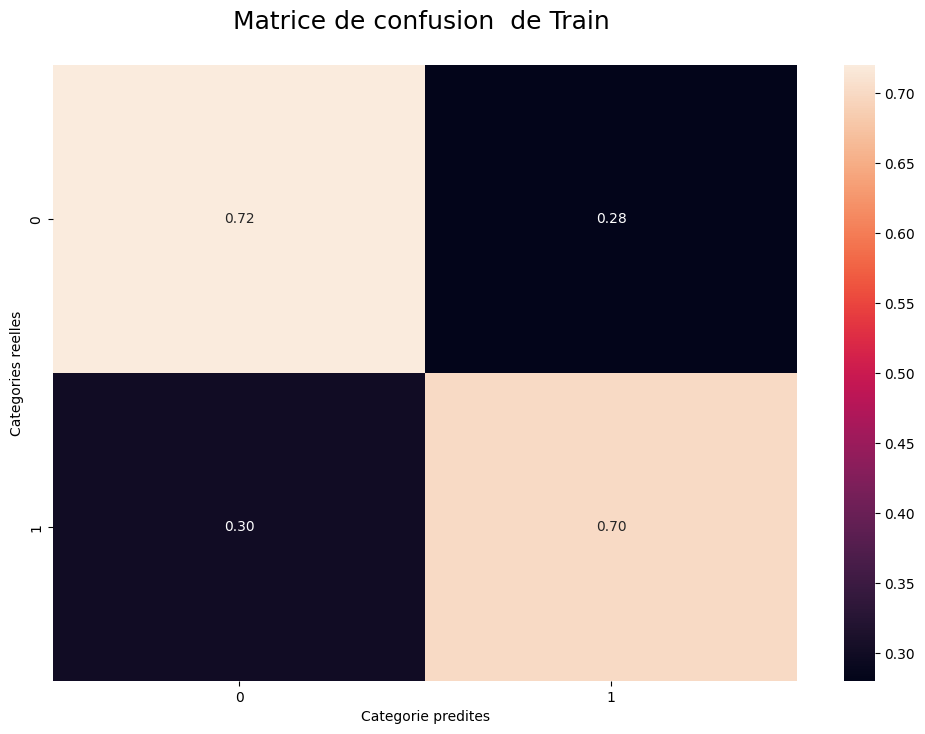

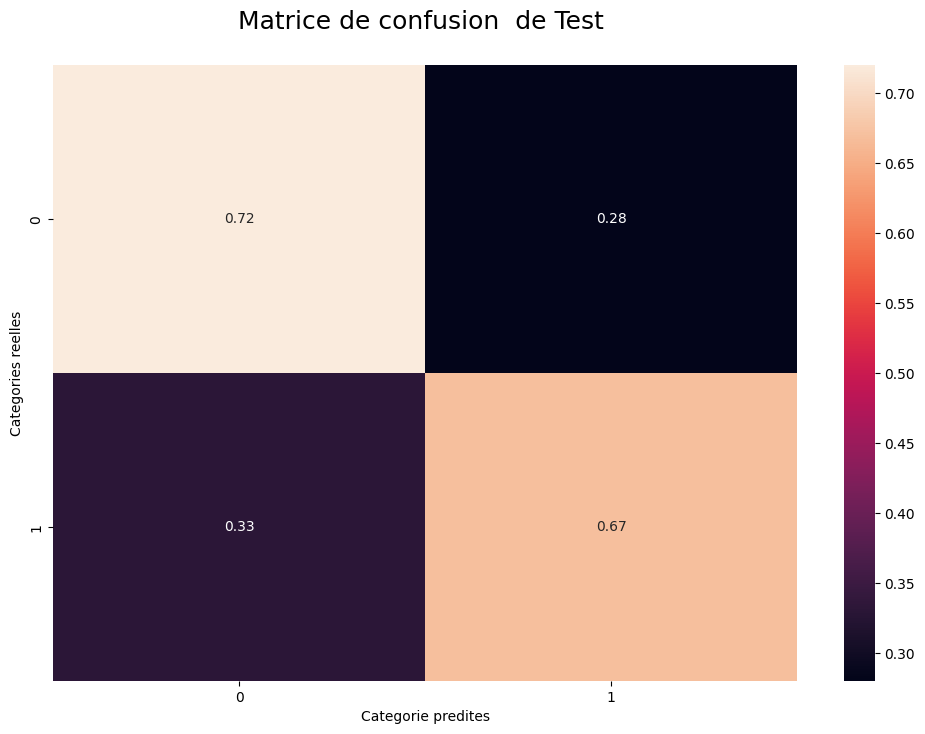

In [26]:
ml810.classification_binaire_save_results(xglob=X, model=model,
                                          xtrain=X_train, ytrain=y_train,
                                          xtest=X_test, ytest=y_test,
                                          nom_model=NOM_MODELE_BASE,
                                          estimator=NOM_MODELE_BASE,
                                          tmp_folder=TMP_FOLDER)